In [11]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline 
import xgboost as xgb
import seaborn as sns 
from xgboost import XGBClassifier
np.random.seed(42) 
sns.set_style('dark')
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score #回归评判标准
from sklearn.metrics import accuracy_score, r2_score, make_scorer, f1_score, recall_score, precision_score,roc_auc_score,confusion_matrix #分类评判依据
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

### 导入数据

In [3]:
orig_data = pd.read_excel(r"F:\1\data1\全国数据\ML营地\ML_camp_county\train_minmax_county.xlsx")

In [4]:
X = orig_data.iloc[ :,4:10]
y = orig_data.iloc[:,-1]
X

,DEM,GDP,NDVI,POP,RIVER,ROAD
0,0.022131,0.062483,0.613872,0.160557,0.157143,0.053152
1,0.013677,0.045211,0.532568,0.192191,0.142857,0.071671
2,0.022042,0.098790,0.647406,0.198442,0.142857,0.094137
3,0.145783,0.001140,0.939812,0.007260,0.142857,0.007027
4,0.077805,0.002331,0.835735,0.018344,0.142857,0.014803
...,...,...,...,...,...,...
1978,0.002916,0.000806,0.894777,0.015360,0.161905,0.005886
1979,0.191840,0.000228,0.973863,0.003610,0.154639,0.000837
1980,0.206081,0.000440,0.793080,0.005771,0.142857,0.001127
1981,0.208915,0.000047,0.905375,0.000550,0.165024,0.000792


In [5]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1978    0
1979    0
1980    0
1981    0
1982    0
Name: new_label, Length: 1983, dtype: int64

In [6]:
print(X.shape,y.shape)

(1983, 6) (1983,)


c:\Users\XZD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

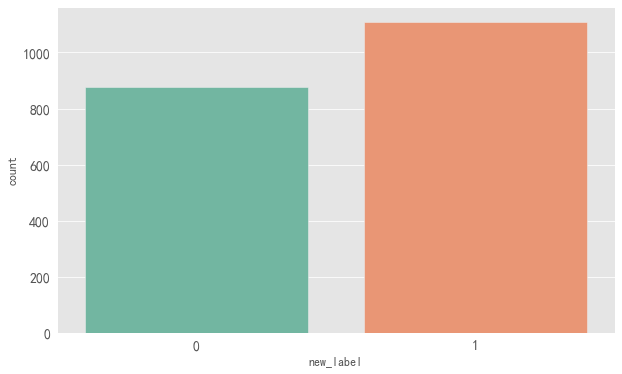

In [108]:
#绘制样本分布情况
plt.figure(figsize=(10, 6))
sns.countplot(y, palette="Set2")
plt.xticks(rotation=0)

### 绘制变量相关性

<AxesSubplot:>

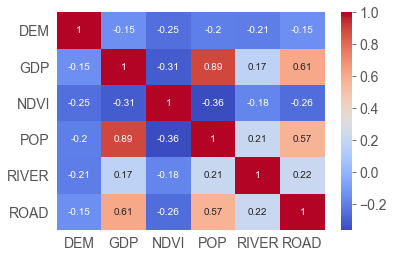

In [7]:
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)

### 划分训练集、测试集，并标准化

In [8]:
# 划分数据集，80% 训练数据和 20% 测试数据
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print(X_train.shape,y_train.shape)

(1388, 6) (1388,)


### 测试模型基准训练水平

In [24]:

xgb_clf = XGBClassifier(objective='binary:logistic',eval_metric='auc',use_label_encoder=False, seed=2021)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_train)

In [25]:
from sklearn.model_selection import cross_val_score

# Ten-fold cross validation
scores = cross_val_score(xgb_clf, X_train, y_train,
                        scoring = "accuracy", cv=10,
                        n_jobs=-1)
def display_scores(scores):

    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.60431655 0.63309353 0.64028777 0.60431655 0.67625899 0.5323741
 0.5971223  0.62589928 0.63043478 0.67391304]
Mean: 0.6218016890835157
Standard deviation: 0.03931867061726279


### 随机搜索方法调整模型参数（可探索其他调参方式）

In [33]:
xgb = XGBClassifier(objective='binary:logistic',
                    eval_metric = 'auc', tree_method='hist', seed=2021,importance_type = 'cover',use_label_encoder=False)
""" 
指定学习任务参数：
    objective目标函数。
        二分类   常用binary:logistic 回归任务reg:linear
        多分类   multi:softmax,需要指定类别数量，'num_class':33
        回归任务 reg:linear
    eval_metric 评价函数。
        二分类   常用auc和logloss
        多分类   mlogloss
        回归任务 均方误差mse,均方根误差rmse, 平均绝对值误差mae

"""

调整树模型参数

In [43]:
learning_rate = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
#学习速率。用于控制树的权重，xgb模型在进行完每一轮迭代之后，会将叶子节点的分数乘上该系数，以便于削弱各棵树的影响，避免过拟合。
boost_params = ["gblinear", "gbtree"]
#选择每次迭代的模型。gbtree和dart用于树模型，而gblinear更适用线性模型，gbtree效果远胜gblinear。一般对eta调优时会结合迭代次数进行考虑。
base_score = [0.05,0.15,0.25,0.50,0.75]
#对于所有样本预测为正样本的全局偏置。如果迭代次数够多，改变这个参数对结果不会有影响。
max_depth = [2,3,4,5,6,7,8,9,10]  
#树的最大深度[default=6]。一般取值范围为[3,10]，对结果影响较大，越深模型越复杂，越容易过拟合
alpha = [0.1,0.3,0.5,0.7,0.9, 1] 
#L1正则 [default=0]。增大该值将使模型更保守。一般我们做特征选择的时候会用L1正则项。
colsample_bytree= [0.5,0.6,0.7,0.8,0.9,1]
#用于每次分裂一颗树时随机样本（列）采样的比例,即选择多少列作为训练集[default=1]，具体的理解就是选择多少特征.取值范围为：（0,1]，一般取值为[0.5,1]
min_child_weight = [1,2,3,4,5,6,7,8,9] 
#分裂的叶子节点中样本权重和的最小值[default=1]。如果新分裂的节点的样本权重和小于min_child_weight则停止分裂。增大min_child_weight可以减少过拟合。取值范围为：[0,]。
n_estimators = [100,200,300,400,500,600,700,800,1000] #树的棵树
'''
gamma:用于限制在叶子节点上进一步分裂所需的最小损失函数下降值。分裂节点时,损失函数减小值只有大于等于gamma节点才分裂。gamma越大,算法越保守。取值范围为[0,]一般0.1、0.2这样子
lambda:L2正则 [default=1].增大lambda将使模型可以缓解模型的过拟合。因为加入了惩罚项L2之后,参数公式是w=(X^T XλI)^(-1) X^T Y。可以看出来加入L2正则项使得矩阵正定,将各个特征的贡献都均匀了。
subsample:用于每次分裂一颗树时随机样本(行)采样的比例。取值范围为:(0,1],但是一般取值[0.5,1],当取值为0.5时,较取值1时更能阻止过拟合的发生。
silent: 是否打印训练过程中的信息,0表示打印,1反之
scale_pos_weight [default=1]
用于调节样本不均衡的情况。一般取值可以为：负样本数/正样本数。
'''
params = {
    "colsample_bytree":colsample_bytree,
    "booster":boost_params,
    "max_depth":max_depth,
    "learning_rate":learning_rate,
    "min_child_weight":min_child_weight,
    "n_estimators":n_estimators,
    "base_score":base_score,
    'alpha':alpha
}

xgb_rs = RandomizedSearchCV(xgb, param_distributions=params, cv=10, scoring='accuracy', n_jobs=-1, n_iter=50, random_state=100)
#n_jobs：运行的线程数，-1所有线程，该值需要根据具体情况调整，线程对最终结果有一点影响，曾今测试，线程越多，结果会变差一丢丢
#random_state：这个随机指定一个常数，防止每次结果不一致
#n_inter迭代计算次数，由于网格搜索是随机的，因此可以增加 n_iter 参数以提高性能
xgb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='cover',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                   param_distributions={'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                        'base_score': [0.05, 0.15, 0.25, 0.5,
                        

In [45]:
xgb_rs.best_params_ #打印搜索出的最佳参数

{'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7,
 'booster': 'gbtree',
 'base_score': 0.15,
 'alpha': 0.5}

In [46]:
xgb_rs.best_score_ #打印最佳得分

0.6434574079866542

In [47]:
xgb_rs.best_estimator_ #打印最佳模型的各项参数

XGBClassifier(alpha=0.5, base_score=0.15, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, seed=2021, subsample=1, tree_method='hist',
              use_label_encoder=False, ...)

In [113]:
features = list(X.columns)
importances = xgb_rs.best_estimator_.feature_importances_
indices = np.argsort(importances)
df4 = pd.DataFrame({'features':features,'importances':importances})
#df4.to_excel('fig5-trace.xlsx')
df4

,features,importances
0,DEM,0.143482
1,GDP,0.185319
2,NDVI,0.184919
3,POP,0.164377
4,RIVER,0.166286
5,ROAD,0.155616


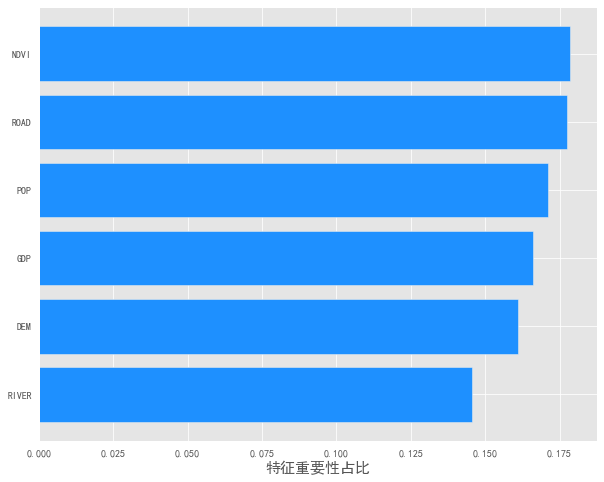

In [117]:
plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices],color='dodgerblue',align='center')#绘制柱形图
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('特征重要性占比',fontsize=15)
plt.savefig('FeatureImportance.jpg', dpi=900)
plt.show()

In [52]:
from sklearn.model_selection import cross_val_score

# ten-fold cross validation
scores = cross_val_score(xgb_rs.best_estimator_, X_train, y_train,
                        scoring = "accuracy", cv=10,
                        n_jobs=-1)
def display_scores(scores):
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(scores)

Scores: [0.61870504 0.64748201 0.63309353 0.63309353 0.70503597 0.52517986
 0.63309353 0.63309353 0.71014493 0.69565217]
Mean: 0.6434574079866542
Standard deviation: 0.05100150510051608


In [53]:
# predict the test data set
xgb_test = xgb_rs.best_estimator_
xgb_test.fit(X_train,y_train)
y_test_pred = xgb_test.predict(X_test)


In [58]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test, y_test_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

Accuracy: 0.632
ROC AUC: 0.622
Precision: 0.659
Recall: 0.709
F1 Score: 0.683


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       262
           1       0.66      0.71      0.68       333

    accuracy                           0.63       595
   macro avg       0.62      0.62      0.62       595
weighted avg       0.63      0.63      0.63       595



In [63]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print(confmat)

[[140 122]
 [ 97 236]]


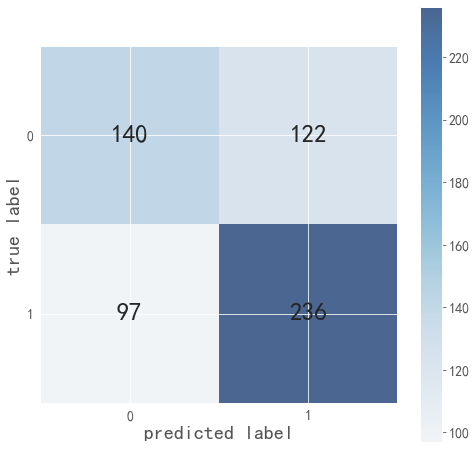

In [86]:
plt.figure(figsize=(8, 8))  #设置图片大小

#设置全局字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

#热力图绘制
plt.imshow(confmat, cmap=plt.cm.Blues,alpha=0.7)#绘制heatmap  
plt.colorbar() #显示colorbar

classes=[0,1]#定义类别
indices = range(len(confmat))#坐标的显示顺序
plt.xticks(indices, classes)#画x轴刻度
plt.yticks(indices, classes)#画y轴刻度

plt.xlabel('predicted label',fontsize=20) #显示x轴标题
plt.ylabel('true label',fontsize=20) #显示y标题


#显示数字文字
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        plt.text(x=j, y=i, s=confmat[i,j], va='center', ha='center',fontsize=25)


#plt.savefig('Major1 Confusion.png', dpi=900)
plt.show()

In [98]:
#predict the non label data
predict_data = pd.read_excel (r"F:\1\data1\全国数据\ML营地\ML_camp_county\predict_minmax_county.xls")
x_predict_data = predict_data.iloc[ :,4:10]
x_predict_data

,DEM,GDP,NDVI,POP,RIVER,ROAD
0,0.251205,0.000017,0.001673,0.000200,0.143109,0.000303
1,0.026929,0.154448,0.823530,0.240048,0.142857,0.254019
2,0.253106,0.000017,0.093458,0.000069,0.145124,0.000235
3,0.314543,0.000190,0.341026,0.002156,0.164835,0.000803
4,0.044838,0.001374,0.901479,0.007570,0.142857,0.003261
...,...,...,...,...,...,...
2850,0.116176,0.000820,0.647959,0.007792,0.163711,0.002281
2851,0.268434,0.000025,0.280549,0.001130,0.155015,0.001075
2852,0.061732,0.000471,0.754607,0.003651,0.142857,0.000957
2853,0.002825,0.039886,0.312296,0.115532,0.142857,1.000000


In [99]:
predict_data

,FID,PAC,NAME,省,DEM,GDP,NDVI,POP,RIVER,ROAD,count
0,2639,620982,敦煌市,甘肃省,0.251205,0.000017,0.001673,0.000200,0.143109,0.000303,72
1,2897,810000,香港特别行政区,香港特别行政区,0.026929,0.154448,0.823530,0.240048,0.142857,0.254019,40
2,417,152921,阿拉善左旗,内蒙古自治区,0.253106,0.000017,0.093458,0.000069,0.145124,0.000235,38
3,2744,640502,沙坡头区,宁夏回族自治区,0.314543,0.000190,0.341026,0.002156,0.164835,0.000803,35
4,860,330523,安吉县,浙江省,0.044838,0.001374,0.901479,0.007570,0.142857,0.003261,26
...,...,...,...,...,...,...,...,...,...,...,...
2850,2850,659008,可克达拉市,新疆维吾尔自治区,0.116176,0.000820,0.647959,0.007792,0.163711,0.002281,0
2851,2851,659009,昆玉市,新疆维吾尔自治区,0.268434,0.000025,0.280549,0.001130,0.155015,0.001075,0
2852,2852,659010,胡杨河市,新疆维吾尔自治区,0.061732,0.000471,0.754607,0.003651,0.142857,0.000957,0
2853,2881,710109,中正区,台湾省,0.002825,0.039886,0.312296,0.115532,0.142857,1.000000,0


In [100]:
predict_results = xgb_rs.best_estimator_.predict_proba(x_predict_data)
predict_results

array([[0.23705852, 0.7629415 ],
       [0.17909598, 0.820904  ],
       [0.34493017, 0.6550698 ],
       ...,
       [0.51004136, 0.48995867],
       [0.3564986 , 0.6435014 ],
       [0.75095165, 0.24904832]], dtype=float32)

In [101]:
df_predict = pd.DataFrame(data=predict_results)
df_predict

,0,1
0,0.237059,0.762941
1,0.179096,0.820904
2,0.344930,0.655070
3,0.496955,0.503045
4,0.112585,0.887415
...,...,...
2850,0.247638,0.752362
2851,0.669234,0.330766
2852,0.510041,0.489959
2853,0.356499,0.643501


In [105]:
results = pd.concat([df_predict,predict_data],axis=1)
#objs 表示需要连接的对象，比如：[df1, df2]，需要将合并的数据用综括号包围
#axis=0 表拼接方式是上下堆叠，当axis=1表示左右拼接；
results
results.to_excel('predict_results1017.xlsx')